In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

前面我们学习了卷积神经网络（convnet），并知道它在计算机视觉问题上表现出色，原因在于它能够进行卷积运算，从局部输入图块中提取特征，并能够将表示模块化，同时可以高效地利用数据。这些性质让卷积神经网络在计算机视觉领域表现优异，同样也让它对序列处理特别有效。

**时间可以被看作一个空间维度，就像二维图像的高度或宽度。对于某些序列处理问题，这种一维卷积神经网络的效果可以媲美RNN，而且计算代价通常要小很多**。

最近，**一维卷积神经网络［通常与空洞卷积核（dilated kernel）一起使用］已经在音频生成和机器翻译领域取得了巨大成功**。除了这些具体的成就，人们还早已知道，**对于文本分类和时间序列预测等简单任务，小型的一维卷积神经网络可以替代RNN，而且速度更快。**

# 1 理解序列数据的一维卷积

前面介绍的卷积层都是二维卷积，从图像张量中提取二维图块并对每个图块应用相同的变换。按照同样的方法，你也可以使用一维卷积，从序列中提取局部一维序列段（即子序列），见图。

![image.png](../img/06/一维卷积神经网络的工作原理.png)

这种一维卷积层可以**识别序列中的局部模式**。因为**对每个序列段执行相同的输入变换，所以在句子中某个位置学到的模式稍后可以在其他位置被识别**，这使得**一维卷积神经网络具有平移不变性（对于时间平移而言）**。

举个例子，使用大小为5的卷积窗口处理字符序列的一维卷积神经网络，应该能够学习长度不大于5的单词或单词片段，并且应该能够在输入句子中的任何位置识别这些单词或单词段。因此，字符级的一维卷积神经网络能够学会单词构词法。

# 2 序列数据的一维池化

二维平均池化和二维最大池化，在卷积神经网络中用于对图像张量进行空间下采样。一维也可以做相同的池化运算：从输入中提取一维序列段（即子序列），然后输出其最大值（最大池化）或平均值（平均池化）。与二维卷积神经网络一样，该运算也是用于降低一维输入的长度（子采样）。

# 3 实现一维卷积神经网络

`Keras`中的一维卷积神经网络是`Conv1D`层，其接口类似于`Conv2D`。它接收的输入是形状为`(samples, time, features)`的三维张量，并返回类似形状的三维张量。卷积窗口是**时间轴上的一维窗口（时间轴是输入张量的第二个轴）**。

我们来构建一个简单的两层一维卷积神经网络，并将其应用于我们熟悉的IMDB 情感分类任务。

In [2]:
# 准备IMDB 数据

from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


一维卷积神经网络的架构与第5 章的二维卷积神经网络相同，它是Conv1D 层和MaxPooling1D层的堆叠，最后是一个全局池化层或Flatten 层，将三维输出转换为二维输出，让你可以向模型中添加一个或多个Dense 层，用于分类或回归。

不过二者有一点不同：一维卷积神经网络可以使用更大的卷积窗口。对于二维卷积层，3×3 的卷积窗口包含3×3=9 个特征向量；但对于一位卷积层，大小为3 的卷积窗口只包含3个卷积向量。因此，你可以轻松使用大小等于7 或9 的一维卷积窗口。

In [3]:
# 在IMDB 数据上训练并评估一个简单的一维卷积神经网络
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


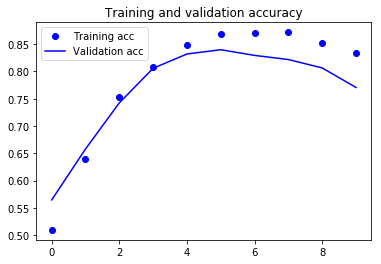

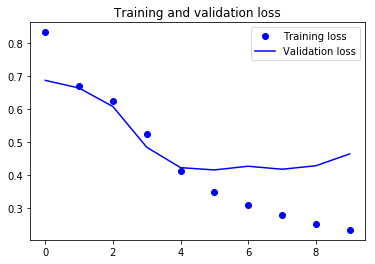

In [4]:
# 模型的训练结果和验证结果

%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

上面了模型的训练结果和验证结果。验证精度略低于LSTM，但在CPU 和GPU 上的运行速度都要更快（速度提高多少取决于具体配置，会有很大差异）。现在，你可以使用正确的轮数（4 轮）重新训练这个模型，然后在测试集上运行。这个结果可以让我们确信，在单词级的情感分类任务上，一维卷积神经网络可以替代循环网络，并且速度更快、计算代价更低。

# 4 结合CNN 和RNN 来处理长序列

一维卷积神经网络分别处理每个输入序列段，所以它对时间步的顺序不敏感（这里所说顺序的范围要大于局部尺度，即大于卷积窗口的大小），这一点与RNN 不同。当然，为了识别更长期的模式，你可以将许多卷积层和池化层堆叠在一起，这样上面的层能够观察到原始输入中更长的序列段，但这仍然不是一种引入顺序敏感性的好方法。想要证明这种方法的不足，一种方法是在温度预测问题上使用一维卷积神经网络，在这个问题中顺序敏感性对良好的预测结果非常关键。以下示例复用了前面定义的这些变量：`float_data`、`train_gen`、`val_gen` 和`val_steps`。

In [5]:
# # 在耶拿数据上训练并评估一个简单的一维卷积神经网络
# from keras.models import Sequential
# from keras import layers
# from keras.optimizers import RMSprop
# model = Sequential()
# model.add(layers.Conv1D(32, 5, activation='relu',
# input_shape=(None, float_data.shape[-1])))
# model.add(layers.MaxPooling1D(3))
# model.add(layers.Conv1D(32, 5, activation='relu'))
# model.add(layers.MaxPooling1D(3))
# model.add(layers.Conv1D(32, 5, activation='relu'))
# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.Dense(1))
# model.compile(optimizer=RMSprop(), loss='mae')
# history = model.fit_generator(train_gen,
#                               steps_per_epoch=500,
#                               epochs=20,
#                               validation_data=val_gen,
#                               validation_steps=val_steps)

验证MAE 停留在`0.4~0.5`，使用小型卷积神经网络甚至无法击败基于常识的基准方法。同样，这是因为卷积神经网络在输入时间序列的所有位置寻找模式，它并不知道所看到某个模式的时间位置（距开始多长时间，距结束多长时间等）。对于这个具体的预测问题，对最新数据点的解释与对较早数据点的解释应该并不相同，所以卷积神经网络无法得到有意义的结果。卷积神经网络的这种限制对于`IMDB`数据来说并不是问题，因为对于与正面情绪或负面情绪相关联的关键词模式，无论出现在输入句子中的什么位置，它所包含的信息量是一样的。

要想结合卷积神经网络的速度和轻量与RNN 的顺序敏感性，一种方法是在RNN 前面使用一维卷积神经网络作为预处理步骤（见图6-30）。对于那些非常长，以至于RNN 无法处理的序列（比如包含上千个时间步的序列），这种方法尤其有用。卷积神经网络可以将长的输入序列转换为高级特征组成的更短序列（下采样）。然后，提取的特征组成的这些序列成为网络中RNN 的输入。

![image.png](../img/06/结合CNN和RNN.png)

这种方法非常有效，应该被更多人使用。我们尝试将其应用于温度预测数据集。因为**这种方法允许操作更长的序列，所以我们可以查看更早的数据（通过增大数据生成器的lookback 参数）或查看分辨率更高的时间序列（通过减小生成器的step 参数）**。这里我们**任意地将step 减半，得到时间序列的长度变为之前的两倍，温度数据的采样频率变为每30 分钟一个数据点**。本示例复用了之前定义的generator 函数。

In [7]:
# 为耶拿数据集准备更高分辨率的数据生成器
import os
import numpy as np

data_dir = r'D:\git\deep-learning-with-python\data\jena_climate_2009_2016'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
# 结合一维卷积基和GRU 层的模型
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 25s 50ms/step - loss: 0.4198 - val_loss: 0.4356
Epoch 2/20
500/500 [==============================] - 24s 47ms/step - loss: 0.3651 - val_loss: 0.4494
Epoch 3/20
500/500 [==============================] - 24s 48ms/step - loss: 0.3415 - val_loss: 0.4724
Epoch 4/20
500/500 [==============================] - 25s 50ms/step - loss: 0.3244 - val_loss: 0.4556
Epoch 5/20
500/500 [==============================] - 24s 48ms/step - loss: 0.3089 - val_loss: 0.4508
Epoch 6/20
500/500 [==============================] - 24s 49ms/step - loss: 0.3010 - val_loss: 0.4612
Epoch 7/20
500/500 [==============================] - 24s 48ms/step - loss: 0.2924 - val_loss: 0.4673
Epoch 8/20
500/500 [==============================] - 24s 49ms/step - loss: 0.2857 - val_loss: 0.4698
Epoch 9/20
500/500 [==============================] - 24s 48ms/step - loss: 0.2786 - val_loss: 0.4980
Epoch 10/20
500/500 [==============================] - 24s 48ms/step - loss: 0.274

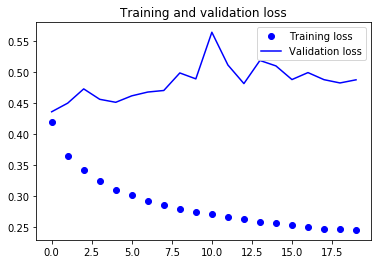

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从验证损失来看，这种架构的效果不如只用正则化GRU，但速度要快很多。它查看了两倍的数据量，在本例中可能不是非常有用，但对于其他数据集可能非常重要。

下面是你应该从本节中学到的要点。
* 二维卷积神经网络在二维空间中处理视觉模式时表现很好，与此相同，一维卷积神经网络在处理时间模式时表现也很好。对于某些问题，特别是自然语言处理任务，它可以替代RNN，并且速度更快。
* 通常情况下，一维卷积神经网络的架构与计算机视觉领域的二维卷积神经网络很相似，它将Conv1D 层和MaxPooling1D 层堆叠在一起，最后是一个全局池化运算或展平操作。
* 因为 RNN 在处理非常长的序列时计算代价很大，但一维卷积神经网络的计算代价很小，所以在RNN 之前使用一维卷积神经网络作为预处理步骤是一个好主意，这样可以使序列变短，并提取出有用的表示交给RNN 来处理。

总结
* 你在本章学到了以下技术，它们广泛应用于序列数据（从文本到时间序列）组成的数据集。
* 如何对文本分词。
* 什么是词嵌入，如何使用词嵌入。
* 什么是循环网络，如何使用循环网络。
* 如何堆叠 RNN层和使用双向RNN，以构建更加强大的序列处理模型。
* 如何使用一维卷积神经网络来处理序列。
* 如何结合一维卷积神经网络和 RNN来处理长序列。
* 你可以用 RNN 进行时间序列回归（“预测未来”）、时间序列分类、时间序列异常检测和序列标记（比如找出句子中的人名或日期）。
* 同样，你可以将一维卷积神经网络用于机器翻译（序列到序列的卷积模型，比如SliceNet）、文档分类和拼写校正。
* 如果序列数据的整体顺序很重要，那么最好使用循环网络来处理。时间序列通常都是这样，最近的数据可能比久远的数据包含更多的信息量。
* 如果整体顺序没有意义，那么一维卷积神经网络可以实现同样好的效果，而且计算代价更小。文本数据通常都是这样，在句首发现关键词和在句尾发现关键词一样都很有意义。